In [1]:
import numpy as np
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, least_squares
from scipy.integrate import odeint
from datetime import date

In [2]:
df_names = ['confirmed_global', 'deaths_global', 'recovered_global'] 
df_list = [pd.DataFrame() for df in df_names]
df_dict = dict(zip(df_names, df_list))

url_part = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_'

for key, value in df_dict.items():
    value = pd.read_csv(url_part+key+'.csv', parse_dates=[0])
    
    value.rename(columns={'Province/State': 'Province_State', 'Country/Region': 'Country_Region'}, inplace=True)
    
    dim_col = value.columns[0:4]
    date_col = value.columns[4:]
    
    value = value.melt(id_vars = dim_col, value_vars = date_col, var_name = 'Date', value_name = key)
    
    value['Date'] = pd.to_datetime(value['Date'])
    
    df_dict[key] = value

join_on_col = ['Province_State','Country_Region','Lat','Long','Date']
df_COVID = df_dict['confirmed_global'].merge(df_dict['deaths_global'], on=join_on_col, how='outer').merge(df_dict['recovered_global'], on=join_on_col, how='outer')
df_COVID.rename(columns = {'confirmed_global':'Confirmed', 'deaths_global':'Deaths', 'recovered_global':'Recovered'}, inplace = True)

df_COVID = df_COVID.set_index(['Country_Region', 'Province_State', 'Date'])

In [3]:
data = df_COVID.loc['India']
data = data.reset_index().groupby('Date').sum()

In [4]:
data = data[data['Confirmed'] > 100]

In [5]:
data

,Province_State,Lat,Long,Confirmed,Deaths,Recovered
Date,,,,,,
2020-03-14,0.0,21.0,78.0,102.0,2.0,4.0
2020-03-15,0.0,21.0,78.0,113.0,2.0,13.0
2020-03-16,0.0,21.0,78.0,119.0,2.0,13.0
2020-03-17,0.0,21.0,78.0,142.0,3.0,14.0
2020-03-18,0.0,21.0,78.0,156.0,3.0,14.0
2020-03-19,0.0,21.0,78.0,194.0,4.0,15.0
2020-03-20,0.0,21.0,78.0,244.0,5.0,20.0
2020-03-21,0.0,21.0,78.0,330.0,4.0,23.0
2020-03-22,0.0,21.0,78.0,396.0,7.0,27.0


In [6]:
data = data.reset_index()
first_date = data['Date'].min()
data['Dias'] = list(map(lambda x : (x-first_date).days, data['Date']))

In [7]:
class Chunker(object):
    """Split `iterable` on evenly sized chunks.

    Leftovers are remembered and yielded at the next call.
    """
    def __init__(self, chunksize):
        assert chunksize > 0
        self.chunksize = chunksize        
        self.chunk = []

    def __call__(self, iterable):
        """Yield items from `iterable` `self.chunksize` at the time."""
        assert len(self.chunk) < self.chunksize
        for item in iterable:
            self.chunk.append(item)
            if len(self.chunk) == self.chunksize:
                # yield collected full chunk
                yield self.chunk
                self.chunk = []

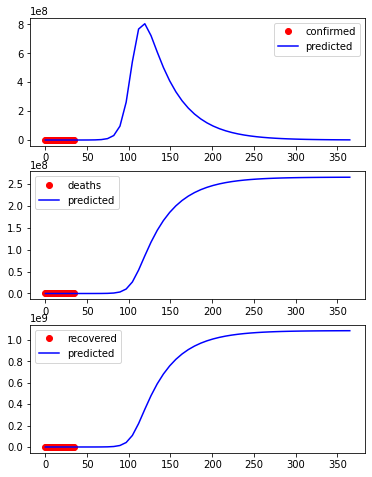

In [8]:
rdata = data['Recovered'].to_numpy()
ddata = data['Deaths'].to_numpy()
idata = (data['Confirmed'].to_numpy() - ddata - rdata)
ydata = np.hstack([idata])
xdata = data['Dias']

N  = 1353000000 #11460000
D0 = 0
R0 = 0
I0 = data.iloc[0]['Confirmed'] - D0 - R0
E0 = 0
S0 = N-I0-E0-D0-R0
te = 5.2

def _ode_func(y, t, b, d, r):
    S, E, I, R, D = y
    # differential equations
    dSdt  = -b*I*S/N
    dEdt  = b*I*S/N - E/te
    dIdt  = E/te - (r+d)*I
    dRdt  = r*I + d*I
    return dSdt, dEdt, dIdt, dRdt, dDdt

def compute_single(t, b, d, r):
    global y0
    values  = odeint(_ode_func, y0, t, args=(b, d, r))
    return values.T

def fit_all(t, y):
    global y0
    def ajust_many(params):
        b = params[0]
        d = params[1]
        r = params[2]
        values  = odeint(_ode_func, y0, t, args=(b, d, r))
        S, E, I, R, D = values.T
        EIR = E + I + R
        return np.hstack([I, R, D]) - y
    params0 = (1, 1, 1)
    res = least_squares(ajust_many, params0, bounds=(0, np.inf))
    return res.x

x = np.linspace(0, 365)
y0 = S0, E0, I0, R0, D0
k_fit = fit_all(xdata, ydata)
S, E, I, R, D = compute_single(x, *k_fit)

plt.figure(figsize=(6,8))
plt.subplot(3,1,1)
plt.plot(xdata, idata, 'ro', label='confirmed')
plt.plot(x, I, 'b-', label='predicted')
plt.legend(loc='best')
plt.subplot(3,1,2)
plt.plot(xdata, ddata, 'ro', label='deaths')
plt.plot(x, D, 'b-', label='predicted')
plt.legend(loc='best')
plt.subplot(3,1,3)
plt.plot(xdata, rdata, 'ro', label='recovered')
plt.plot(x, R, 'b-', label='predicted')
plt.legend(loc='best')


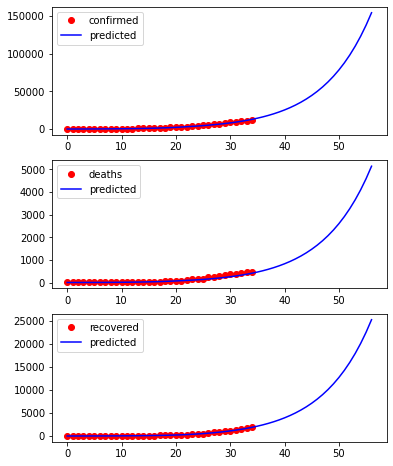

In [9]:
def ajust_beta_piecewise(xdata, idata, rdata, ddata, extrapolation=0, chunk_size=7, overlap=7):
    global y0
    b = []
    results = []
    y0 = [S0, E0, I0, R0, D0]
    xdata = np.array(xdata)
    for i in range(0, len(xdata), chunk_size):
        n = i+chunk_size+overlap
        if n > len(xdata):
            break
            y = np.hstack([idata[i:], rdata[i:], ddata[i:]])
            x = xdata[i:]
        else:
            y = np.hstack([idata[i:n], rdata[i:n], ddata[i:n]])
            x = xdata[i:n]
        x = x-x[0]
        k_fit = fit_all(x, y)
        b.append(k_fit)
        res = compute_single(x, *k_fit)
        if n > len(xdata):
            results.append(res)
            y0 = res[:,-1]
        else:
            results.append(res[:,:chunk_size])
            y0 = res[:,chunk_size]
    if extrapolation > 0:
        results.append(compute_single(range(1, extrapolation), *k_fit))
    return np.array(b), np.block(results)

plt.figure(figsize=(6,8))
betas, fit = ajust_beta_piecewise(xdata, idata, rdata, ddata, extrapolation=30)
y = fit[2,:]
x = range(len(y))
plt.subplot(3,1,1)
plt.plot(xdata, idata, 'ro', label='confirmed')
plt.plot(x, y, 'b-', label='predicted')
plt.legend(loc='best')
plt.subplot(3,1,2)
y = fit[-1,:]
x = range(len(y))
plt.plot(xdata, ddata, 'ro', label='deaths')
plt.plot(x, y, 'b-', label='predicted')
plt.legend(loc='best')
plt.subplot(3,1,3)
y = fit[-2,:]
x = range(len(y))
plt.plot(xdata, rdata, 'ro', label='recovered')
plt.plot(x, y, 'b-', label='predicted')
plt.legend(loc='best')

In [10]:
betas

array([[0.45009725, 0.00343084, 0.01483179],
       [0.35717668, 0.00549971, 0.01513466],
       [0.32952842, 0.0051483 , 0.01606804],
       [0.21454514, 0.00377551, 0.0186766 ]])

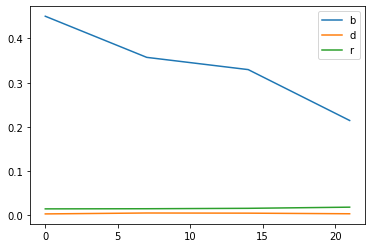

In [11]:
x = range(0, 7*len(betas), 7)
plt.plot(x, betas[:,0], '-', label='b')
plt.plot(x, betas[:,1], '-', label='d')
plt.plot(x, betas[:,2], '-', label='r')
plt.legend(loc='best')